In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# loading in the dataset
df = pd.read_csv("cars.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13058 entries, 0 to 13057
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model year            12758 non-null  float64
 1   Make                  12758 non-null  object 
 2   Model                 12758 non-null  object 
 3   Vehicle class         12758 non-null  object 
 4   Engine size (L)       12758 non-null  float64
 5   Cylinders             12758 non-null  float64
 6   Transmission          12758 non-null  object 
 7   Fuel type             12758 non-null  object 
 8   City (L/100 km)       12758 non-null  float64
 9   Highway (L/100 km)    12758 non-null  float64
 10  Combined (L/100 km)   12758 non-null  float64
 11  Combined (mpg)        12758 non-null  float64
 12  CO2 emissions (g/km)  12758 non-null  float64
 13  CO2 rating            11313 non-null  float64
 14  Smog rating           9925 non-null   float64
dtypes: float64(10), obj

Dataset Information

Number of Entries: 13085
Number of Features: 15

Data Preprocessing

In [4]:
# filtering out cars with any missing values
df.dropna(inplace=True)

In [5]:
# converting appropriate fields to integer fields
integer_fields = ["Model year", "Cylinders", "CO2 emissions (g/km)", "Smog rating"]
for field in integer_fields:
    df[field] = df[field].astype(int)

In [6]:
# converting the oddly-labeled fuel type abbreviations to their brand name for clarity
fuel_type_mapping = {
    "D": "Diesel",
    "Z": "Premium",
    "E": "Flex-Fuel",
    "X": "Regular"
}

df["Fuel type"] = df["Fuel type"].map(fuel_type_mapping)

**Data Exploration**

In [7]:
df.describe()

,Model year,Engine size (L),Cylinders,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
count,9925.000000,9925.000000,9925.000000,9925.000000,9925.000000,9925.000000,9925.000000,9925.000000,9925.000000,9925.000000
mean,14627.711537,7.608161,17.662569,83.405783,25.231668,30.128363,152.662771,880.834458,7.745693,8.242720
std,43051.336310,16.922279,43.758335,251.410708,56.386432,67.659845,445.125579,2201.387160,11.897851,12.829244
min,2017.000000,0.900000,3.000000,4.000000,3.900000,4.000000,11.000000,94.000000,1.000000,1.000000
25%,2018.000000,2.000000,4.000000,10.300000,7.800000,9.200000,23.000000,215.000000,4.000000,3.000000
50%,2021.000000,3.000000,6.000000,12.400000,9.200000,11.000000,27.000000,259.000000,5.000000,5.000000
75%,2023.000000,4.300000,8.000000,15.300000,11.100000,13.400000,33.000000,310.000000,6.000000,7.000000
max,161920.000000,127.300000,336.000000,1912.600000,372.600000,492.200000,4071.000000,15520.000000,100.000000,80.000000


Removing entries with non-sensical attributes

In [8]:
# max model year cant be more than 2025 (current year)
df = df[df["Model year"] <= 2025]

# max engine size can't be more than 28.4L
df = df[df["Engine size (L)"] <= 28.4]

# max cylinders can't be more than 16
df = df[df["Cylinders"] <= 16]

# the best performing car is only getting 57mpg right now
df = df[df["Combined (mpg)"] <= 57]

df.describe()

,Model year,Engine size (L),Cylinders,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
count,9066.000000,9066.000000,9066.000000,9066.000000,9066.000000,9066.000000,9066.000000,9066.000000,9066.000000,9066.000000
mean,2020.305647,3.152923,5.639643,12.527675,9.252868,11.053309,27.128833,256.636223,4.497794,4.786675
std,2.264819,1.341884,1.900089,3.339670,2.164642,2.764424,6.785416,60.269655,1.511875,1.788528
min,2017.000000,0.900000,3.000000,4.800000,4.500000,5.000000,11.000000,114.000000,1.000000,1.000000
25%,2018.000000,2.000000,4.000000,10.200000,7.700000,9.100000,22.000000,213.000000,3.000000,3.000000
50%,2020.000000,3.000000,6.000000,12.150000,9.000000,10.700000,26.000000,253.000000,4.000000,5.000000
75%,2022.000000,3.700000,6.000000,14.500000,10.500000,12.700000,31.000000,295.000000,5.000000,6.000000
max,2024.000000,8.400000,16.000000,30.700000,20.900000,26.100000,56.000000,608.000000,10.000000,8.000000


**Hypothesis Testing**

Engine Size related to C02 Emissions?

Largers engines generally burn more fuel than smaller engines. However, vehicles using larger engines are on the highway more often than not so their fuel efficiency might be better (relative to the engine size) than smaller engine vehicles that spend a lot of time starting and stopping in local streets. It makes sense to test this relationship.

**Regression**<br>
H0: Engine Size and CO₂ Emissions are not related<br>
HA: Engine Size and CO₂ Emissions are related

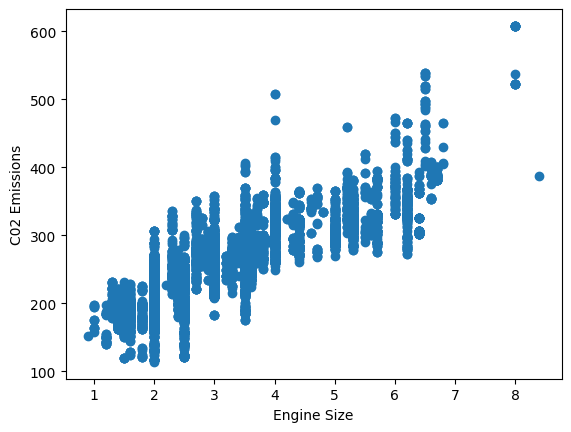

In [9]:
# visualizing hypothesis
plt.scatter(df["Engine size (L)"], df["CO2 emissions (g/km)"])
plt.xlabel("Engine Size")
plt.ylabel("C02 Emissions")
plt.show()

In [10]:
# computing p-value from regression analysis
result = linregress(df["Engine size (L)"], df["CO2 emissions (g/km)"])
print("p-value:", result.pvalue)

p-value: 0.0


Engine Size and CO2 emmissions are definetly related

Engine Size & C0

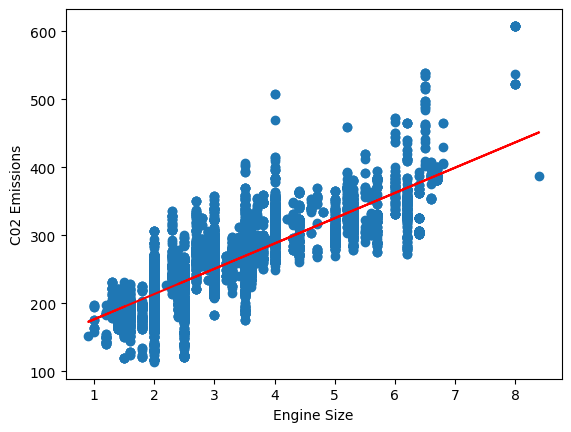

In [11]:
plt.scatter(df["Engine size (L)"], df["CO2 emissions (g/km)"])
plt.xlabel("Engine Size")
plt.ylabel("C02 Emissions")
plt.plot(df["Engine size (L)"], result.intercept + result.slope*df["Engine size (L)"], 'r', label='fitted line')
plt.show()

**One-Way ANOVA**<br>
H0: Fuel type does not affect CO2 emissions<br>
HA: Fuel type significantly affects CO2 emissions

In [12]:
# Get the list of fuel types and corresponding emissions
fuel_groups = [group['CO2 emissions (g/km)'].values
               for name, group in df.groupby('Fuel type')]

# Run ANOVA
f_stat, p_value = f_oneway(*fuel_groups)
print("ANOVA Test Results:")
print(f"F-statistic = {f_stat:.3f}")
print(f"P-value = {p_value:.5f}")

ANOVA Test Results:
F-statistic = 267.219
P-value = 0.00000


/var/folders/4j/bzjzr7sx5cv9skphgq447myw0000gn/T/ipykernel_83017/2492406405.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fuel type', y='CO2 emissions (g/km)', palette='Set3')


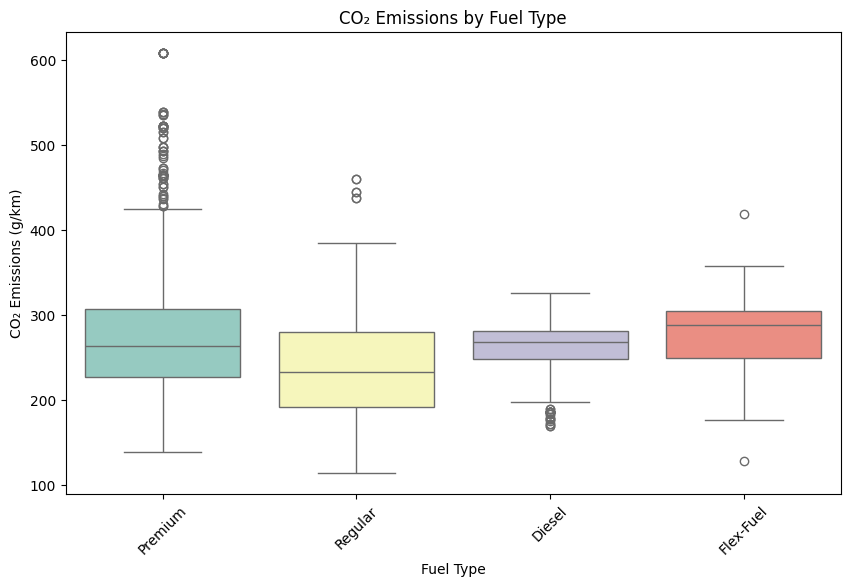

In [13]:
# Visualization
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Fuel type', y='CO2 emissions (g/km)', palette='Set3')
plt.title('CO₂ Emissions by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('CO₂ Emissions (g/km)')
plt.xticks(rotation=45)
plt.show()

**Follow-Up Tukey Test**

**Chi-Square Test of Independence**<br>
H0: There is no association between fuel type and smog rating category.<br>
HA: There is an association between fuel type and smog rating category.<br><br>

Note -> Regarding smog ratings, vehicles that score a 10 are the **cleanest**. The categories are defined as such:<br>
Low: 1–3

Medium: 4–7

High: 8–10

In [14]:
# Creating smog rating categories
def categorize_smog(rating):
    if rating <= 3:
        return "Low"
    elif rating <= 7:
        return "Medium"
    else:
        return "High"

df["Smog Category"] = df["Smog rating"].apply(categorize_smog)

# Build the contingency table
contingency = pd.crosstab(df["Fuel type"], df["Smog Category"])

# Run the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency)
print("\nChi-square test results:")
print(f"Chi2 Statistic: {chi2:.3f}")
print(f"P-value: {p:.4f}")


Chi-square test results:
Chi2 Statistic: 920.987
P-value: 0.0000


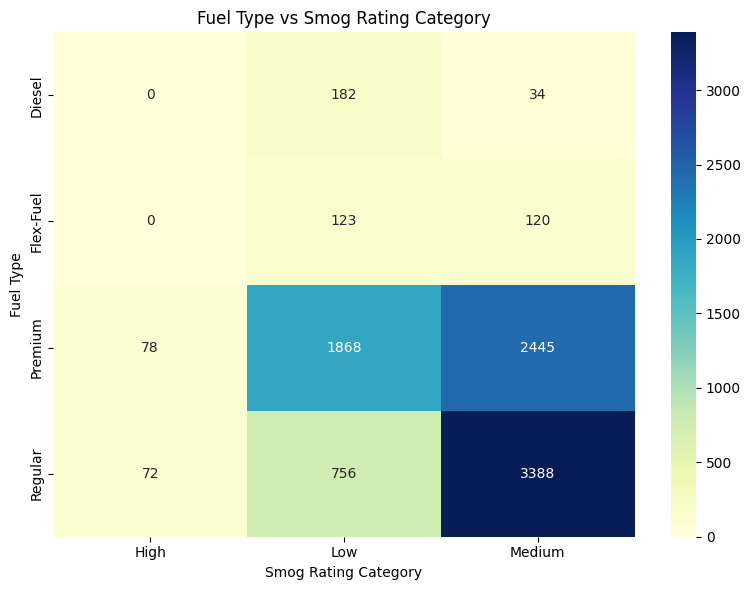

In [15]:
# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(contingency, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Fuel Type vs Smog Rating Category")
plt.xlabel("Smog Rating Category")
plt.ylabel("Fuel Type")
plt.tight_layout()
plt.show()